In [104]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers, Sequential

for g in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

print(tf.config.list_physical_devices())

np.random.seed(42)
tf.random.set_seed(42)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [105]:
import kagglehub 

path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /home/talha/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/3


In [106]:
import os
AUTOTUNE = tf.data.AUTOTUNE

classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_path = os.path.join(path, "Training")
test_path = os.path.join(path, "Testing")

class_names = tf.constant(classes)
class_ids = tf.range(len(classes), dtype=tf.int32)
label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(class_names, class_ids),
    default_value=-1
)

In [ ]:
# TODO: Check whether there is data leakage

In [107]:
def parse_image_label(filepath):
    """Will take filepath as input preprocesses, and returns images with assigned labels"""
    label = tf.strings.split(filepath, os.sep)[-2]
    label = label_table.lookup(label)
    
    image_bytes = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image_bytes)[...,0]
    image = tf.image.resize(image[..., tf.newaxis], [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.squeeze(image, axis=-1)

    return image, label

In [123]:
def create_dataset(path, classes, shuffle_buffer=100, batch_size=32, augment_data=False):
    filepaths = []
    for class_ in classes:
        pattern = os.path.join(path, class_, "*.jpg") 
        filepaths.extend(tf.io.gfile.glob(pattern))

    shuffled_filepaths = np.random.choice(filepaths, len(filepaths), replace=False)
    filepaths_list = tf.data.Dataset.from_tensor_slices(shuffled_filepaths)
    dataset = filepaths_list.map(parse_image_label, num_parallel_calls=AUTOTUNE).shuffle(shuffle_buffer)

    if augment_data:
        data_augmentation = Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
            layers.RandomTranslation(0.05, 0.05),
            layers.RandomContrast(0.1)
        ])
        
        def augment_data(image, label):
            image_batched = tf.expand_dims(image, 0) # batch_dimension
            augmented_image = data_augmentation(image_batched, training=True)
            augmented_image = tf.squeeze(augmented_image, 0)
            return augmented_image, label
        
        augmented_ds = dataset.map(augment_data, num_parallel_calls=AUTOTUNE)
        dataset = dataset.concatenate(augmented_ds)

    return dataset

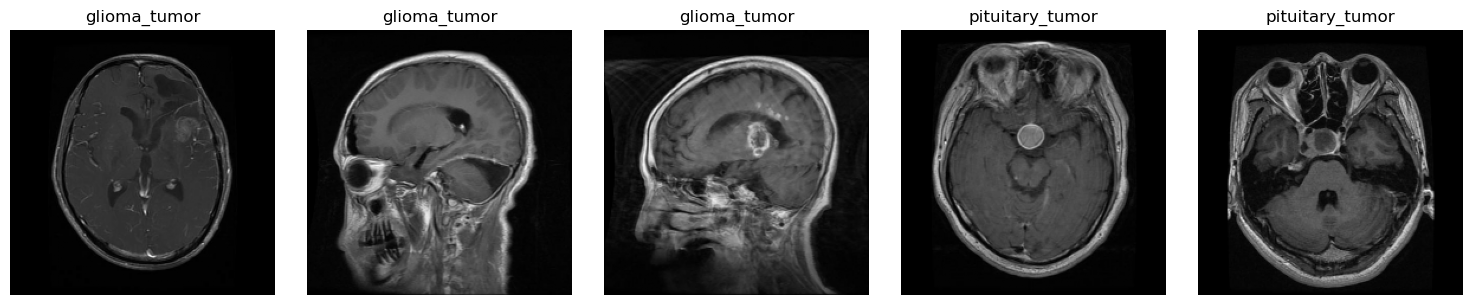

In [124]:
ds = create_dataset(train_path, classes, augment_data=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i, (image, label) in enumerate(ds.take(5)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.numpy(), cmap="gray")
    plt.title(classes[label.numpy()])
    plt.axis("off")
plt.tight_layout()
plt.show()